In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from chexnet import ChexNet
from unet import Unet
from dataset import ChestXray14Dataset
from transform import tta
from metrics import aucs
from constant import CLASS_NAMES, IMAGENET_MEAN, IMAGENET_STD
from fastai.conv_learner import *
from transform import chest_xray_transfrom

import pandas as pd
import skimage
from scipy import ndimage
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms

In [3]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
CSV_FILE = 'test.csv'
DISEASES = np.array(CLASS_NAMES)

In [4]:
chexnet_model = '20180429-130928'
chexnet = ChexNet(trained=True, model_name=chexnet_model).cuda()
chexnet.eval();

In [5]:
col_names = ['Image File'] + CLASS_NAMES
df = pd.read_csv(PATH/CSV_FILE, header=None, sep=' ', names=col_names)
all_files = list(df['Image File'].values)

In [40]:
image_files = random.sample(all_files, 16)

In [7]:
with open(PATH/'cut_all.pickle', 'rb') as f:
    d = pickle.load(f)

In [8]:
_, tfm = chest_xray_transfrom(224, 0.875)

In [44]:
i = random.randint(0, 15)
# image_file = '00030561_007.png' # '00023091_009.png'
# image_file = '00027900_000.png' # '00013685_060.png'
# image_file = '00005839_004.png'

 Edema:	1.000
 Infiltration:	0.958
 Pneumonia:	0.926
 Consolidation:	0.852
 Cardiomegaly:	0.837
 Effusion:	0.494
 Nodule:	0.427
 Mass:	0.234
 Atelectasis:	0.042
 Pleural Thickening:	0.033

00013685_060.png


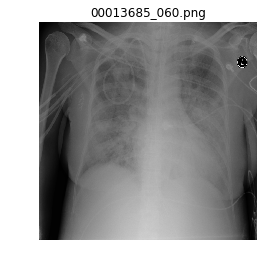

In [45]:
image = Image.open(PATH/IMAGE_DN/image_files[i]).convert('RGB')
coords = d[image_files[i]].split(' ')
bb = list(map(lambda x: int(x), coords))
plt.imshow(image)
plt.axis('off')
plt.title(image_files[i])
plt.savefig('predict.png', transparent=True, bbox_inches='tight', pad_inches=0)


img = image.crop(bb)
img = tfm(img)
py = torch.sigmoid(chexnet(V(img[None])))

# get gt
gt = df[df['Image File'] == image_files[i]]
gt = DISEASES[np.where(gt[CLASS_NAMES].values[0]==1)]
if gt.size == 0:
    gt = 'No Finding'

# get top probs
top=10
probs = py.detach().cpu().numpy()[0]
idx = np.argsort(-probs)
ps = probs[idx[:top]]
diseases = DISEASES[idx[:top]]

# print(gt)
txt = ''
if 'No Finding' in gt:
    txt = '\033[34m No Finding\n'
for disease, p in zip(diseases, ps):
    if disease in gt: color = '\033[34m'
    else: color = '\033[30m'
    txt += f'{color} {disease}:\t{p:0.3f}\n'
#     ax.text(0, 0, txt, size=12, transform=ax.transAxes)
print(txt)
print(image_files[i])

In [219]:
print('\033[34m blue')

 blue


'00005646_006.png'